In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.gridspec as gridspec
import scipy.stats as stats
from scipy.signal import savgol_filter
%matplotlib inline
pd.set_option('expand_frame_repr', False)

def line(x, a, b):
    return a*x + b

In [2]:
data_500_l1 = np.loadtxt('./Data/com-500_l1.dat')
data_500_l2 = np.loadtxt('./Data/com-500_l2.dat')
data_500_l3 = np.loadtxt('./Data/com-500_l3.dat')
data_500_l4 = np.loadtxt('./Data/com-500_l4.dat')
data_500_l5 = np.loadtxt('./Data/com-500_l5.dat')

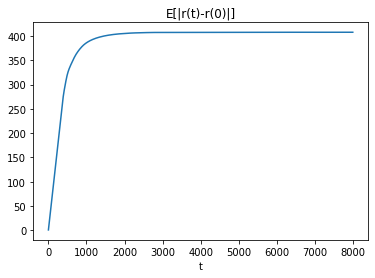

In [3]:
data_500 = np.vstack((data_500_l1, data_500_l2, data_500_l3, data_500_l4, data_500_l5))
split_500 = np.array_split(data_500, 1280)
dpt_500 = np.subtract(split_500, 500)
m_500 = np.mean(dpt_500, axis=0)
msd_500 = np.var(dpt_500, axis=0)

ev = np.linalg.norm(m_500, axis=1)
plt.plot(ev)
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.show()

From which we can see conclude an equilibrium is reached. From the graph, its slope might be of interest

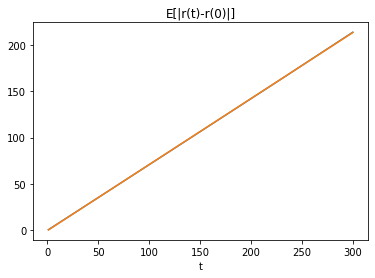

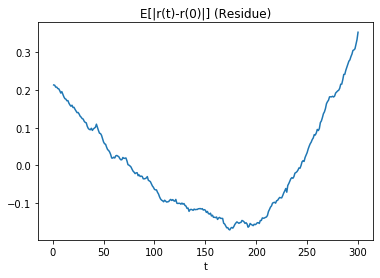

Fit is given by y = 0.7109588669582563x + -0.21787531205043176


In [4]:
x = np.linspace(1, 8000, 8000)[:300]
y = ev[:300]

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.show()
plt.plot(x, y-line(x, *popt))
plt.title('E[|r(t)-r(0)|] (Residue)')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So the average speed is around 0.71.

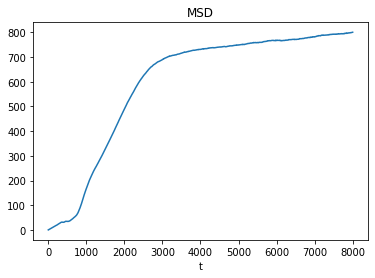

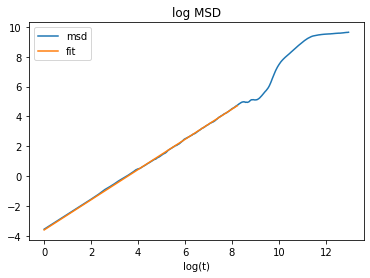

Fit is given by y = 1.0115800260410697x + -3.6018395021869662


In [5]:
msd = msd_500[:, 0] + msd_500[:, 1]
x = np.linspace(1, 8000, 8000)
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')
plt.show()

x = np.log2(np.linspace(1, 8000, 8000))
y = np.log2(msd)
popt, pcov = curve_fit(line, x[:300], y[:300])
plt.plot(x, y, label='msd')
plt.plot(x[:300], line(x[:300], *popt), label='fit')
plt.title('log MSD')
plt.xlabel('log(t)')
plt.legend()
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So the 'spread' behaves diffussively. We will calculate the diffusivity from the graph.
To do so, use 4Dt = MSD, so D = MSD/4.

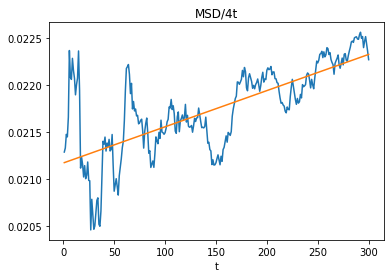

Fit is given by y = 3.844815545573914e-06x + 0.021173198861545714


In [6]:
x = np.linspace(1, 8000, 8000)[:300]
y = np.divide(msd[:300], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So D ~ 0.021, and we will **assume** it's constant

Around step 3000, the behaviour changes. We will now look into it.

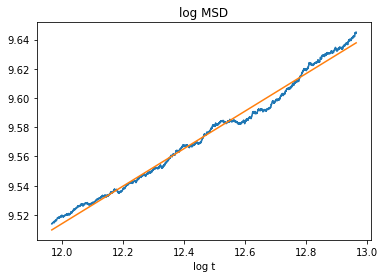

Fit is given by y = 0.1280525302699218x + 7.9774501311776
MSD = t^0.1280525302699218 * 252.02973245478546


In [7]:
x = np.log2(np.linspace(1, 8000, 8000))[4000:8000]
y = np.log2(msd)[4000:8000]
plt.title('log MSD')
plt.xlabel('log t')
plt.plot(x, y)
popt, pcov = curve_fit(line, x, y)
plt.plot(x, line(x, *popt))
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')
print(f'MSD = t^{popt[0]} * {2**popt[1]}')

In any case, the exponent is less than 1, so the system is confined. 

For the middle section, we will calculate the gradient of the log-log function to determine the exponent

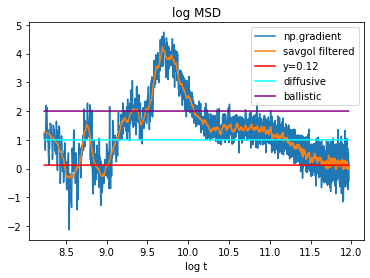

In [8]:
x = np.log2(np.linspace(1, 8000, 8000))[300:4000]
y = np.log2(msd)[300:4000]
gradient = np.gradient(y, x)
plt.plot(x, gradient, label='np.gradient')
smooth = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth, label='savgol filtered')
plt.plot(x, np.zeros(x.size)+0.12, color='red', label='y=0.12')
plt.plot(x, np.zeros(x.size)+1, label='diffusive', color='cyan')
plt.plot(x, np.zeros(x.size)+2, label='ballistic', color='purple')
plt.title('log MSD')
plt.xlabel('log t')
plt.legend()
plt.show()

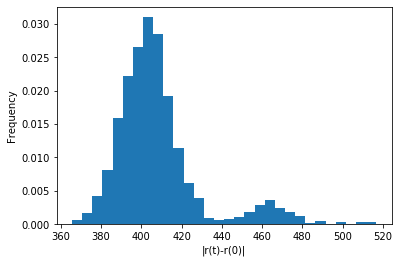

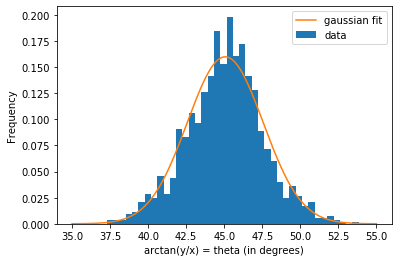

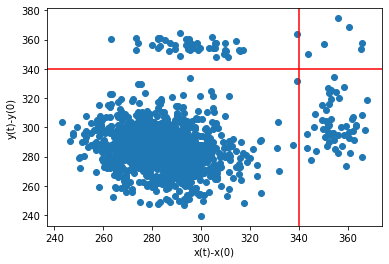

In [9]:
fin_500 = np.subtract(data_500[7999::8000], 500)
plt.hist(np.linalg.norm(fin_500, axis=1), 30, density=True)
plt.xlabel('|r(t)-r(0)|')
plt.ylabel('Frequency')
plt.show()

angles = np.arctan2(fin_500[:, 1], fin_500[:, 0])*180/np.pi
mu = np.mean(angles)
sigma = np.std(angles)
x = np.linspace(35, 55, 1000)
plt.hist(angles, 40, density=True, label='data')
plt.xlabel('arctan(y/x) = theta (in degrees)')
plt.ylabel('Frequency')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit')
plt.legend()
plt.show()

plt.scatter(fin_500[:,0], fin_500[:, 1])
plt.xlabel('x(t)-x(0)')
plt.ylabel('y(t)-y(0)')
plt.axhline(y=340, color='r')
plt.axvline(x=340, color='r')
plt.show()

In [10]:
df = pd.DataFrame(fin_500, columns=['x', 'y'])
df.describe()

,x,y
count,1280.000000,1280.000000
mean,287.920160,288.553509
std,20.228468,19.800671
min,243.271609,239.397225
25%,276.083582,277.354485
50%,285.795815,286.205035
75%,294.587264,296.381854
max,367.826517,374.523115


In [11]:
len(df.loc[(df['x'] > 340) & (df['y'] > 340)])/12.8 # Returns a value out of 100

0.46875

In [12]:
len(df.loc[(df['x'] < 340) & (df['y'] > 340)])/12.8

3.59375

In [13]:
len(df.loc[(df['x'] > 340) & (df['y'] < 340)])/12.8

4.140625

In [14]:
len(df.loc[(df['x'] < 340) & (df['y'] < 340)])/12.8

91.796875

We repeat measurements for different values of v_p and v_d. Starting with v_d = 0.75 v_p = 1

In [15]:
data_v075 = np.loadtxt('./Data/com-d075.dat')
data_v050 = np.loadtxt('./Data/com-d050.dat')

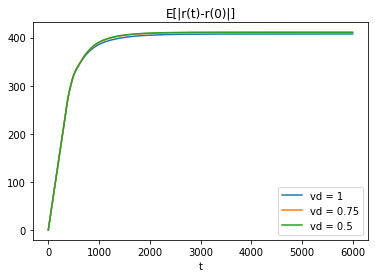

In [16]:
split_v075 = np.array_split(data_v075, 1024)
dpt_v075 = np.subtract(split_v075, 500)
m_v075 = np.mean(dpt_v075, axis=0)
msd_v075 = np.var(dpt_v075, axis=0)

split_v050 = np.array_split(data_v050, 1024)
dpt_v050 = np.subtract(split_v050, 500)
m_v050 = np.mean(dpt_v050, axis=0)
msd_v050 = np.var(dpt_v050, axis=0)

ev = np.linalg.norm(m_500[:6000], axis=1)
plt.plot(ev, label='vd = 1')
ev075 = np.linalg.norm(m_v075, axis=1)
plt.plot(ev075, label='vd = 0.75')
ev050 = np.linalg.norm(m_v050, axis=1)
plt.plot(ev050, label='vd = 0.5')
plt.title('E[|r(t)-r(0)|]')
plt.xlabel('t')
plt.legend()
plt.show()

Take the difference to check how equal they actually are

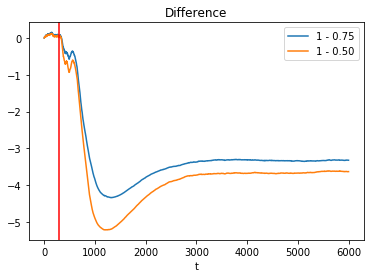

Final difference, 0.75: -3.3208705911476954
Final difference, 0.50: -3.6300799267286266


In [17]:
plt.plot(ev-ev075, label='1 - 0.75')
plt.plot(ev-ev050, label='1 - 0.50')
plt.title('Difference')
plt.xlabel('t')
plt.axvline(x=300, color='r')
plt.legend()
plt.show()
print(f'Final difference, 0.75: {(ev-ev075)[-1]}')
print(f'Final difference, 0.50: {(ev-ev050)[-1]}')

So, on average, the lower v_d system reached dr = 3.32 units further for dv = -0.25. The first steps are largely unchanged

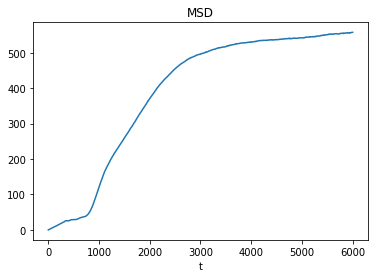

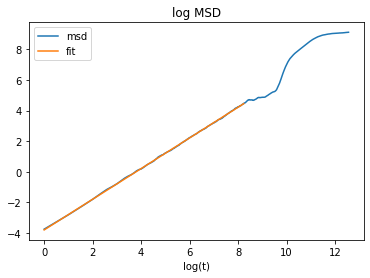

Fit is given by y = 1.002941199544377x + -3.7991920931162033


In [18]:
msd = msd_v075[:, 0] + msd_v075[:, 1]
x = np.linspace(1, 6000, 6000)
y = msd
plt.plot(x, y)
plt.title('MSD')
plt.xlabel('t')
plt.show()

x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd)
popt, pcov = curve_fit(line, x[:300], y[:300])
plt.plot(x, y, label='msd')
plt.plot(x[:300], line(x[:300], *popt), label='fit')
plt.title('log MSD')
plt.xlabel('log(t)')
plt.legend()
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

Final difference - 0.75: 210.9187658244134
Final difference - 0.50: 317.54047457797947


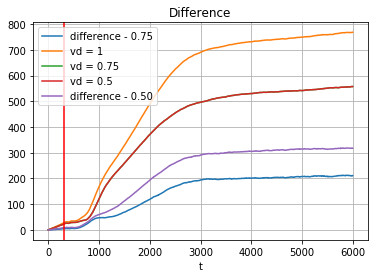

In [19]:
msd1 = (msd_500[:, 0] + msd_500[:, 1])[:6000]
msd075 = msd_v075[:, 0] + msd_v075[:, 1]
plt.plot(msd1-msd075, label='difference - 0.75')
plt.plot(msd1, label='vd = 1')
plt.plot(msd075, label='vd = 0.75')
print(f'Final difference - 0.75: {(msd1-msd075)[-1]}')
msd050 = msd_v050[:, 0] + msd_v050[:, 1]
plt.plot(msd, label='vd = 0.5')
plt.plot(msd1-msd050, label='difference - 0.50')
plt.title('Difference')
plt.xlabel('t')
plt.axvline(x=300, color='r')
plt.legend()
plt.grid()
print(f'Final difference - 0.50: {(msd1-msd050)[-1]}')
plt.show()


So the lower vd systems 'spread' less on average. This is to be expected. For dv = -0.25, have d(msd) = -210.91

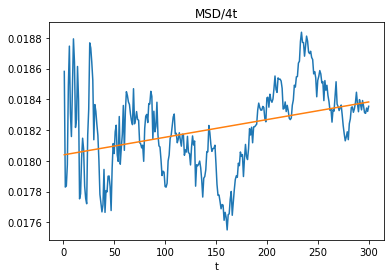

Fit is given by y = 1.147547523526544e-06x + 0.018038661865762643


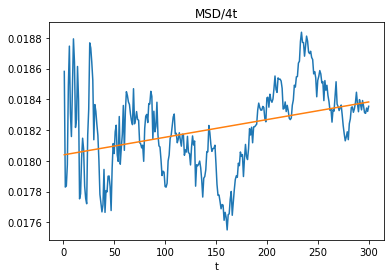

Fit is given by y = 1.147547523526544e-06x + 0.018038661865762643


In [20]:
x = np.linspace(1, 8000, 8000)[:300]
y = np.divide(msd075[:300], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

x = np.linspace(1, 8000, 8000)[:300]
y = np.divide(msd075[:300], 4*x)

popt, pcov = curve_fit(line, x, y)
plt.plot(x, y)
plt.plot(x, line(x, *popt))
plt.title('MSD/4t')
plt.xlabel('t')
plt.show()
print(f'Fit is given by y = {popt[0]}x + {popt[1]}')

So D ~ 0.018, well lower v_d so nothing too out of the norm here either. dv = -0.25 dD = -0.03

We skip the middle section and final section and focus on the final state. (Middle section too complicated, final section looks around the same)

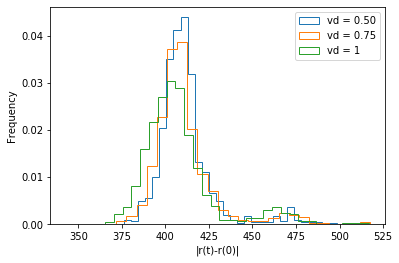

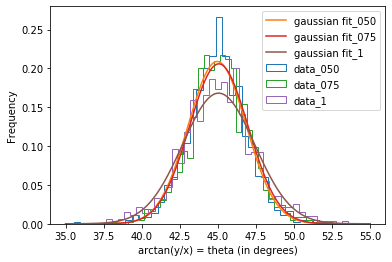

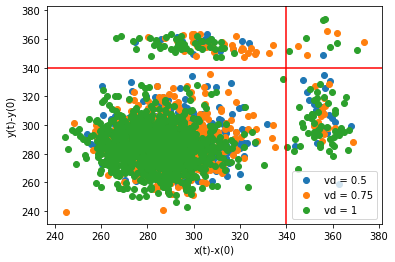

STD difference - 0.75:  0.43467098117958414
STD difference - 0.50:  0.4628065682542293


In [21]:
fin_500 = np.subtract(data_500[5999::8000], 500) # vd = 1
fin_v075 = np.subtract(data_v075[5999::6000], 500)
fin_v050 = np.subtract(data_v050[5999::6000], 500)
plt.hist(np.linalg.norm(fin_v050, axis=1), 30, density=True, histtype='step', label='vd = 0.50')
plt.hist(np.linalg.norm(fin_v075, axis=1), 30, density=True, histtype='step', label='vd = 0.75')
plt.hist(np.linalg.norm(fin_500, axis=1), 30, density=True, histtype='step', label='vd = 1')
plt.legend()
plt.xlabel('|r(t)-r(0)|')
plt.ylabel('Frequency')
plt.show()

angles050 = np.arctan2(fin_v050[:, 1], fin_v050[:, 0])*180/np.pi
mu = np.mean(angles050)
sigma = np.std(angles050)
x = np.linspace(35, 55, 1000)
plt.hist(angles050, 40, density=True, label='data_050', histtype='step')
plt.xlabel('arctan(y/x) = theta (in degrees)')
plt.ylabel('Frequency')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit_050')

angles075 = np.arctan2(fin_v075[:, 1], fin_v075[:, 0])*180/np.pi
mu = np.mean(angles075)
sigma = np.std(angles075)
x = np.linspace(35, 55, 1000)
plt.hist(angles075, 40, density=True, label='data_075', histtype='step')
plt.xlabel('arctan(y/x) = theta (in degrees)')
plt.ylabel('Frequency')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit_075')

angles1 = np.arctan2(fin_500[:, 1], fin_500[:, 0])*180/np.pi
mu = np.mean(angles1)
sigma = np.std(angles1)
x = np.linspace(35, 55, 1000)
plt.hist(angles1, 40, density=True, label='data_1', histtype='step')
plt.plot(x, stats.norm.pdf(x, mu, sigma), label='gaussian fit_1')
plt.legend()
plt.show()

plt.scatter(fin_v050[:,0], fin_v050[:, 1], label='vd = 0.5')
plt.scatter(fin_v075[:,0], fin_v075[:, 1], label='vd = 0.75')
plt.scatter(fin_500[:,0], fin_500[:, 1], label='vd = 1')
plt.xlabel('x(t)-x(0)')
plt.ylabel('y(t)-y(0)')
plt.axhline(y=340, color='r')
plt.axvline(x=340, color='r')
plt.legend()
plt.show()
print(f'STD difference - 0.75:  {np.std(angles1)-np.std(angles075)}')
print(f'STD difference - 0.50:  {np.std(angles1)-np.std(angles050)}')

So dv = -0.25 leads to d(std) = -0.43 in angles.

We compute the gradient in order to find any 'phase differences'. (on the log-log graph of msd)

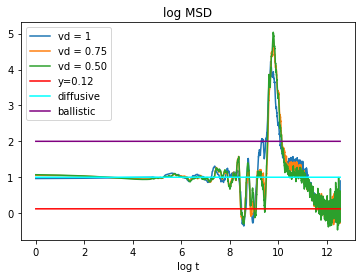

In [22]:
msd1 = (msd_500[:, 0] + msd_500[:, 1])[:6000]
msd075 = msd_v075[:, 0] + msd_v075[:, 1]
msd050 = msd_v050[:, 0] + msd_v050[:, 1]
x = np.log2(np.linspace(1, 6000, 6000))
y = np.log2(msd1)
gradient = np.gradient(y, x)
smooth075 = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth075, label='vd = 1')

y = np.log2(msd075)
gradient = np.gradient(y, x)
smooth1 = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth1, label='vd = 0.75')

y = np.log2(msd050)
gradient = np.gradient(y, x)
smooth050 = savgol_filter(gradient, 51, 2)
plt.plot(x, smooth050, label='vd = 0.50')

plt.plot(x, np.zeros(x.size)+0.12, color='red', label='y=0.12')
plt.plot(x, np.zeros(x.size)+1, label='diffusive', color='cyan')
plt.plot(x, np.zeros(x.size)+2, label='ballistic', color='purple')
plt.title('log MSD')
plt.xlabel('log t')
plt.legend()
plt.show()

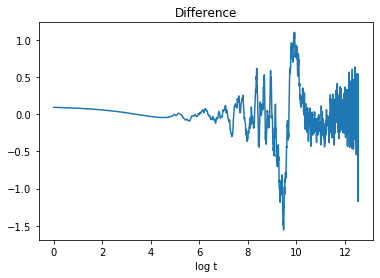

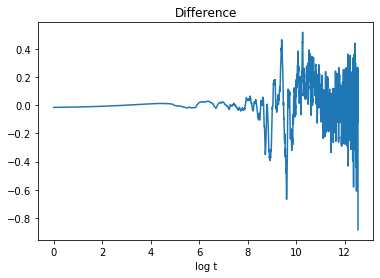

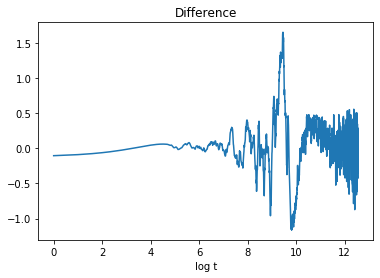

In [23]:
plt.plot(x, smooth1-smooth075)
plt.title('Difference')
plt.xlabel('log t')
plt.show()
plt.plot(x, smooth1-smooth050)
plt.title('Difference')
plt.xlabel('log t')
plt.show()
plt.plot(x, smooth075-smooth050)
plt.title('Difference')
plt.xlabel('log t')
plt.show()

Hard to tell but it looks like no difference to me.

My conclusion: diffusion makes no difference aside from the spread.